Dataset shape: (8000, 19)
Merging sentiment features...
NaN values found in:
  total_spend_std: 147 NaN values
  price_std: 147 NaN values
  quantity_std: 147 NaN values
  price_sensitivity: 147 NaN values
  spending_consistency: 147 NaN values
Enhanced features created! Dataset shape: (1967, 44)
  purchase_frequency: 3 extreme outliers detected
  total_spend: 1 extreme outliers detected
  num_purchases: 3 extreme outliers detected
  spend_per_visit: 7 extreme outliers detected
  average_purchase_value: 7 extreme outliers detected
  monetary_per_month: 147 extreme outliers detected
  purchase_intensity: 23 extreme outliers detected
  days_between_purchases: 5 extreme outliers detected
  purchase_regularity: 206 extreme outliers detected
  recent_activity_ratio: 155 extreme outliers detected
  customer_value_score: 1 extreme outliers detected
k=2: Silhouette Score = 0.1665, Inertia = 46579.31
k=3: Silhouette Score = 0.1469, Inertia = 42108.09
k=4: Silhouette Score = 0.1527, Inertia = 38

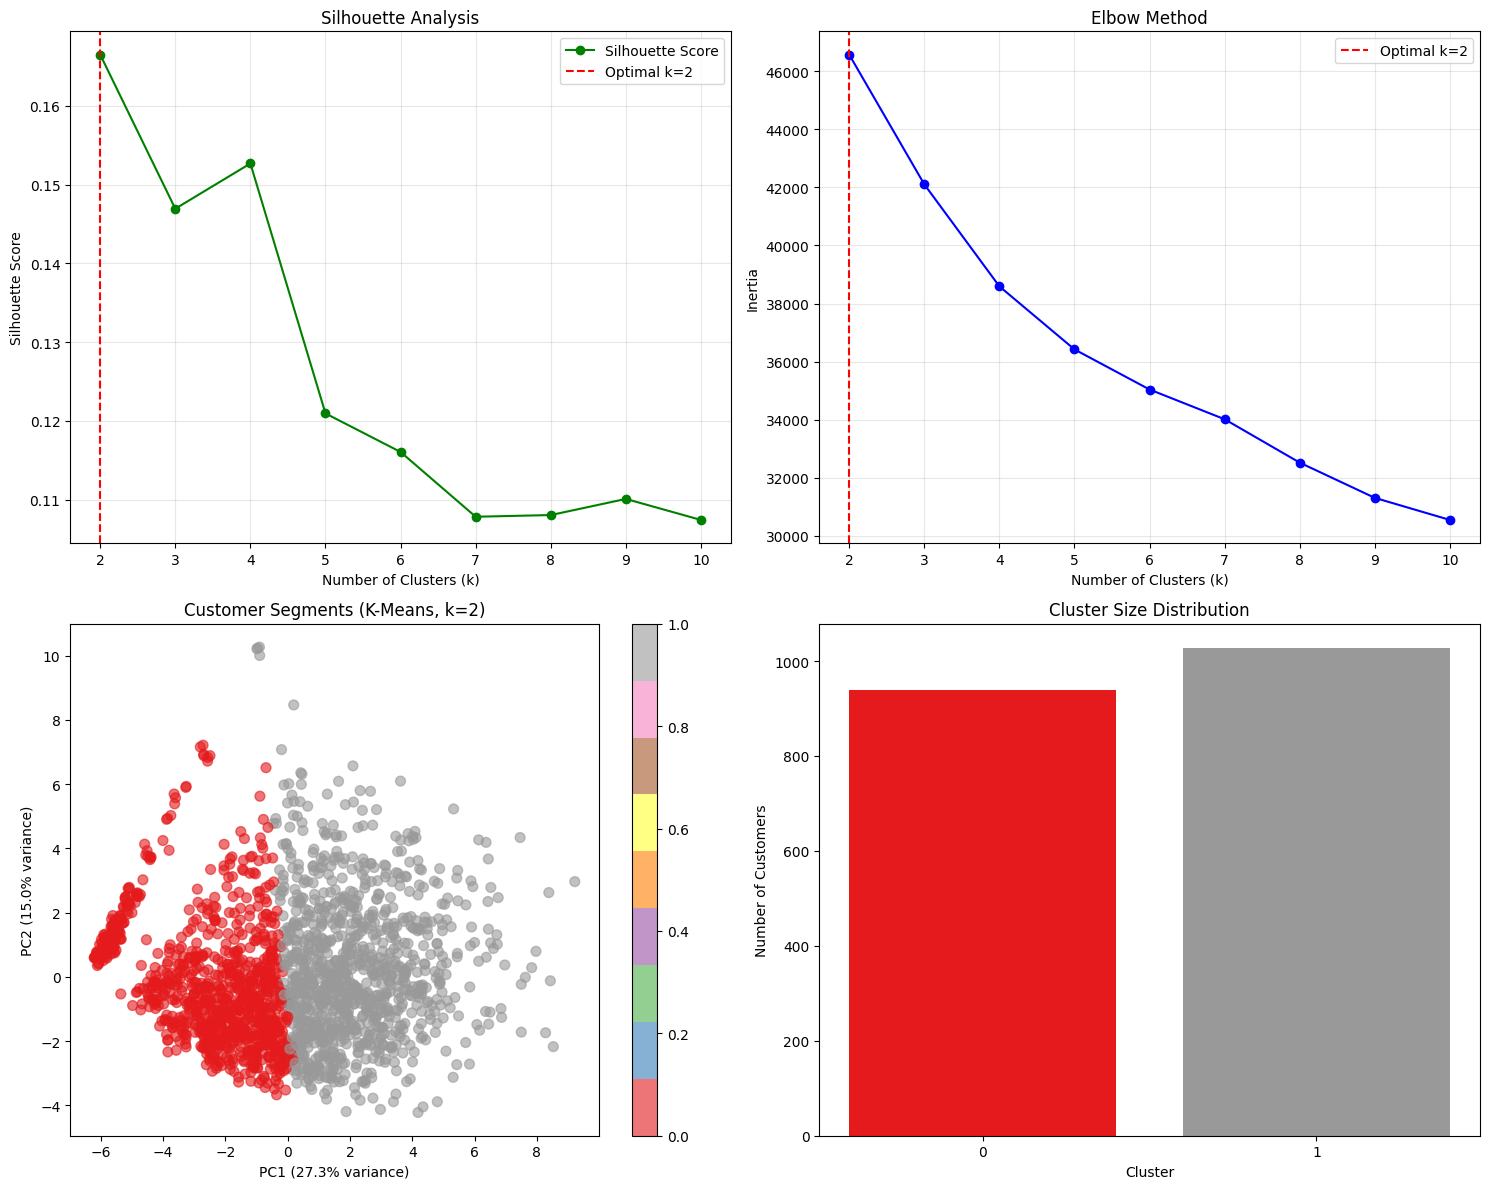


CLUSTER ANALYSIS

Cluster Summary Statistics:
        total_spend            purchase_frequency       recency_days          \
               mean        std               mean   std         mean     std   
cluster                                                                        
0          92996.33   67703.78               2.79  1.18       438.91  340.06   
1         365138.36  173237.51               5.23  1.68       252.77  229.15   

        avg_price           unique_products       customer_value_score  \
             mean       std            mean   std                 mean   
cluster                                                                  
0        13768.77  11585.05            2.43  0.98             37228.80   
1        23711.22  10475.24            4.24  1.22            146106.42   

                  feedback_sentiment        
              std               mean   std  
cluster                                     
0        27081.06               0.31  0.27  
1

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Import sentiment analysis functions from previous code
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# 1. Load dataset
df = pd.read_csv("customer_cleaned.csv")

for c in ['sale_date', 'last_purchase_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])
last_date = df['sale_date'].max()

print(f"Dataset shape: {df.shape}")

# 2. Sentiment Feature Engineering
# ================================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

def get_sentiment_score(text):
    if text == "":
        return 0
    score = sia.polarity_scores(text)
    return score['compound']

def categorize_sentiment(row):
    sentiment_score = row['feedback_sentiment']
    original_text = str(row['feedback_text']).lower()
    
    negative_phrases = [
        "delivery was late, not happy", "delivery late not happy", "late delivery",
        "not happy with delivery", "delayed delivery", "poor delivery",
        "terrible service", "worst experience", "never ordering again",
        "completely disappointed"
    ]
    
    for phrase in negative_phrases:
        if phrase in original_text:
            return "Negative"
    
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Process sentiment if feedback_text exists
if 'feedback_text' in df.columns:
    df['feedback_clean'] = df['feedback_text'].apply(preprocess_text)
    df['feedback_sentiment'] = df['feedback_clean'].apply(get_sentiment_score)
    
    # Aggregate feedback per customer
    customer_feedback = df.groupby('customer_id')['feedback_clean'].apply(lambda x: " ".join(x)).reset_index()
    customer_feedback_original = df.groupby('customer_id')['feedback_text'].apply(lambda x: " ".join(x.fillna(""))).reset_index()
    customer_feedback = customer_feedback.merge(customer_feedback_original, on='customer_id', how='left')
    customer_feedback['feedback_sentiment'] = df.groupby('customer_id')['feedback_sentiment'].mean().values
    customer_feedback['sentiment_category'] = customer_feedback.apply(categorize_sentiment, axis=1)
else:
    customer_feedback = pd.DataFrame()

# 3. Enhanced Feature Engineering
# ===============================
customer_summary = df.groupby("customer_id").agg({
    "sale_id": "count",  # purchase frequency
    "total_value": ["sum", "std", "min", "max"],  # Enhanced total spend metrics
    "price": ["mean", "std", "min", "max"],  # Enhanced price metrics
    "quantity": ["mean", "std", "sum"],  # Enhanced quantity metrics
    "product_id": pd.Series.nunique,  # unique products bought
    "category": pd.Series.nunique,  # number of categories bought
    "last_purchase_date": "max",  # last purchase date
    "sale_date": ["min", "max"],  # First and last purchase dates
    "age": "last",
    "gender": "last",
    "region": "last",
    "segment": "first",
    "tenure_months": "last",
    "churn": "first"
}).reset_index()

# Flatten column names
customer_summary.columns = ['_'.join(col).strip() if col[1] else col[0] 
                           for col in customer_summary.columns.values]
customer_summary.rename(columns={'customer_id_': 'customer_id'}, inplace=True)

# Rename key columns
rename_dict = {
    "sale_id_count": "purchase_frequency",
    "total_value_sum": "total_spend",
    "total_value_std": "total_spend_std",
    "total_value_min": "total_spend_min", 
    "total_value_max": "total_spend_max",
    "price_mean": "avg_price",
    "price_std": "price_std",
    "price_min": "price_min",
    "price_max": "price_max",
    "quantity_mean": "avg_quantity",
    "quantity_std": "quantity_std",
    "quantity_sum": "total_quantity",
    "product_id_nunique": "unique_products",
    "category_nunique": "unique_categories",
    "age_last": "age",
    "gender_last": "gender",
    "region_last": "region",
    "segment_first": "segment",
    "tenure_months_last": "tenure_months",
    "churn_first": "churn"
}
customer_summary.rename(columns=rename_dict, inplace=True)

# 4. Advanced Feature Engineering
# ===============================

#basic features
customer_summary["num_purchases"] = customer_summary["purchase_frequency"]

#recency features
recency = df.groupby("customer_id")["sale_date"].max().apply(lambda x: (last_date - x).days)
customer_summary["recency_days"] = recency.values

first_purchase = df.groupby("customer_id")["sale_date"].min()
customer_summary["days_since_first_purchase"] = (last_date - first_purchase).dt.days.values
customer_summary["customer_lifetime_days"] = (customer_summary["days_since_first_purchase"] - customer_summary["recency_days"])

#purchase pattern features
customer_summary["spend_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)
customer_summary["spend_per_visit"] = customer_summary["total_spend"] / customer_summary["purchase_frequency"].replace(0, 1)
customer_summary["average_purchase_value"] = customer_summary["total_spend"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["monetary_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)

#advanced behavioral features
customer_summary["purchase_intensity"] = customer_summary["num_purchases"] / (customer_summary["days_since_first_purchase"] + 1)
customer_summary["category_diversity_ratio"] = customer_summary["unique_categories"] / customer_summary["unique_products"].replace(0, 1)
customer_summary["avg_items_per_purchase"] = customer_summary["total_quantity"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["price_sensitivity"] = customer_summary["price_std"] / customer_summary["avg_price"].replace(0, 1)
customer_summary["spending_consistency"] = 1 / (customer_summary["total_spend_std"] / customer_summary["total_spend"].replace(0, 1) + 1)
customer_summary["purchase_value_range"] = customer_summary["total_spend_max"] - customer_summary["total_spend_min"]

#temporal features
customer_summary["days_between_purchases"] = customer_summary["customer_lifetime_days"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["purchase_regularity"] = 1 / (customer_summary["days_between_purchases"] + 1)
customer_summary["recent_activity_ratio"] = np.where(customer_summary["recency_days"] > 0, 
                                                    30 / customer_summary["recency_days"], 1)

#value-based features
customer_summary["customer_value_score"] = (customer_summary["total_spend"] * 0.4 + 
                                          customer_summary["purchase_frequency"] * 0.3 + 
                                          (365 - customer_summary["recency_days"].clip(0, 365)) * 0.3)

#merge sentiment features if available
if not customer_feedback.empty:
    print("Merging sentiment features...")
    # Encode sentiment categories
    le_sentiment = LabelEncoder()
    customer_feedback['sentiment_encoded'] = le_sentiment.fit_transform(customer_feedback['sentiment_category'])
    
    customer_summary = customer_summary.merge(
        customer_feedback[['customer_id', 'feedback_sentiment', 'sentiment_encoded']], 
        on='customer_id', 
        how='left'
    )
    customer_summary['feedback_sentiment'] = customer_summary['feedback_sentiment'].fillna(0)
    customer_summary['sentiment_encoded'] = customer_summary['sentiment_encoded'].fillna(1)  # Neutral = 1

#replace infinite values with NaN first
customer_summary = customer_summary.replace([np.inf, -np.inf], np.nan)

#get numeric columns
numeric_cols = customer_summary.select_dtypes(include=[np.number]).columns

#check for NaN values
nan_counts = customer_summary[numeric_cols].isnull().sum()
if nan_counts.sum() > 0:
    print("NaN values found in:")
    for col, count in nan_counts[nan_counts > 0].items():
        print(f"  {col}: {count} NaN values")

#fill NaN values with median (better than mean for outliers)
customer_summary[numeric_cols] = customer_summary[numeric_cols].fillna(
    customer_summary[numeric_cols].median()
)

# For categorical columns, fill with mode
categorical_cols = ['gender', 'region', 'segment']
for col in categorical_cols:
    if col in customer_summary.columns:
        mode_value = customer_summary[col].mode()
        if len(mode_value) > 0:
            customer_summary[col] = customer_summary[col].fillna(mode_value[0])
        else:
            customer_summary[col] = customer_summary[col].fillna('Unknown')

print(f"Enhanced features created! Dataset shape: {customer_summary.shape}")

#Feature Selection for Clustering

base_features = [
    "purchase_frequency", "total_spend", "avg_price",
    "unique_products", "unique_categories", "recency_days",
    "age", "tenure_months", "num_purchases",
    "spend_per_visit", "average_purchase_value",
    "days_since_first_purchase", "monetary_per_month"
]

#enhanced features that improve clustering
enhanced_features = [
    "purchase_intensity", "category_diversity_ratio", 
    "avg_items_per_purchase", "price_sensitivity",
    "spending_consistency", "purchase_value_range",
    "days_between_purchases", "purchase_regularity",
    "recent_activity_ratio", "customer_value_score",
    "price_std", "total_quantity", "customer_lifetime_days"
]

#add sentiment features if available
sentiment_features = []
if not customer_feedback.empty:
    sentiment_features = ["feedback_sentiment", "sentiment_encoded"]

#combine all numeric features
all_numeric_features = base_features + enhanced_features + sentiment_features

#filter features that exist in the dataset
available_features = [f for f in all_numeric_features if f in customer_summary.columns]
categorical_features = ["gender", "region"]



# Data Standardization and Preprocessing

# extreme outliers that might affect standardization

for feature in available_features:
    Q1 = customer_summary[feature].quantile(0.25)
    Q3 = customer_summary[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = ((customer_summary[feature] < lower_bound) | 
                (customer_summary[feature] > upper_bound)).sum()
    if outliers > 0:
        print(f"  {feature}: {outliers} extreme outliers detected")

#apply preprocessing with StandardScaler
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), available_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical_features)
], remainder='drop')

X = preprocessor.fit_transform(customer_summary)

# Optimal Cluster Selection with Properly Standardized Data

silhouette_scores = []
inertia_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X)
    
    sil_score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia_scores.append(kmeans.inertia_)
    
    print(f"k={k}: Silhouette Score = {sil_score:.4f}, Inertia = {kmeans.inertia_:.2f}")

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.4f}")

# Final Clustering with Standardized Data

# Final clustering with standardized data
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = final_kmeans.fit_predict(X)
customer_summary["cluster"] = cluster_labels

# Verify clustering quality
final_silhouette = silhouette_score(X, cluster_labels)
print(f"Final clustering silhouette score: {final_silhouette:.4f}")

# Calculate cluster centers in original feature space (before standardization)
cluster_centers_original = {}
for cluster in range(optimal_k):
    cluster_mask = customer_summary['cluster'] == cluster
    cluster_data = customer_summary[cluster_mask][available_features]
    cluster_centers_original[cluster] = cluster_data.mean()

print(f"✓ Created {optimal_k} clusters with {len(cluster_labels)} customers")

#Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette scores plot
axes[0, 0].plot(K_range, silhouette_scores, 'bo-', color='green', label='Silhouette Score')
axes[0, 0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 0].set_xlabel("Number of Clusters (k)")
axes[0, 0].set_ylabel("Silhouette Score")
axes[0, 0].set_title("Silhouette Analysis")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Elbow method
axes[0, 1].plot(K_range, inertia_scores, 'bo-', color='blue')
axes[0, 1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 1].set_xlabel("Number of Clusters (k)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].set_title("Elbow Method")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

#PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
customer_summary["pca1"] = X_pca[:, 0]
customer_summary["pca2"] = X_pca[:, 1]

scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=customer_summary["cluster"], 
                           cmap='Set1', alpha=0.6, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1, 0].set_title(f'Customer Segments (K-Means, k={optimal_k})')
plt.colorbar(scatter, ax=axes[1, 0])

#Cluster distribution
cluster_counts = customer_summary["cluster"].value_counts().sort_index()
axes[1, 1].bar(range(len(cluster_counts)), cluster_counts.values, 
               color=plt.cm.Set1(np.linspace(0, 1, len(cluster_counts))))
axes[1, 1].set_xlabel("Cluster")
axes[1, 1].set_ylabel("Number of Customers")
axes[1, 1].set_title("Cluster Size Distribution")
axes[1, 1].set_xticks(range(len(cluster_counts)))

plt.tight_layout()
plt.show()

#Cluster Analysis

print("\n" + "="*60)
print("CLUSTER ANALYSIS")
print("="*60)

#key metrics 
analysis_features = ['total_spend', 'purchase_frequency', 'recency_days', 
                    'avg_price', 'unique_products', 'customer_value_score']

if not customer_feedback.empty:
    analysis_features.append('feedback_sentiment')

cluster_summary = customer_summary.groupby('cluster')[analysis_features].agg(['mean', 'std']).round(2)
print("\nCluster Summary Statistics:")
print(cluster_summary)

#customer distribution by cluster
print(f"\nCustomer Distribution:")
for cluster in sorted(customer_summary['cluster'].unique()):
    count = (customer_summary['cluster'] == cluster).sum()
    percentage = count / len(customer_summary) * 100
    print(f"Cluster {cluster}: {count} customers ({percentage:.1f}%)")

#churn rate by cluster
if 'churn' in customer_summary.columns:
    churn_by_cluster = customer_summary.groupby('cluster')['churn'].mean()
    print(f"\nChurn Rate by Cluster:")
    for cluster, churn_rate in churn_by_cluster.items():
        print(f"Cluster {cluster}: {churn_rate:.1%}")


# Export Results
# Create final dataset with cluster assignments
final_dataset = customer_summary[['customer_id', 'cluster'] + available_features + categorical_features + 
                                (['feedback_sentiment', 'sentiment_encoded'] if not customer_feedback.empty else [])]

print(f"\nFinal dataset ready for export with shape: {final_dataset.shape}")
print("Features included:", final_dataset.columns.tolist())

# Save to CSV
final_dataset.to_csv('customer_clusters_enhanced.csv', index=False)
print("Results exported to 'customer_clusters_enhanced.csv'")

In [132]:
import pickle

# Bundle both preprocessor and model for later use
model_bundle = {
    "preprocessor": preprocessor,
    "kmeans": final_kmeans,
    "optimal_k": optimal_k,
    "features": available_features,
    "categorical_features": categorical_features
}

with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

